In [2]:
!pip install torch
!pip install torch-geometric
!pip install numpy
!pip install scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.3 MB/s eta 0:00:00


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
import pandas as pd
import networkx as nx
!pip install --upgrade networkx
import matplotlib.pyplot as plt









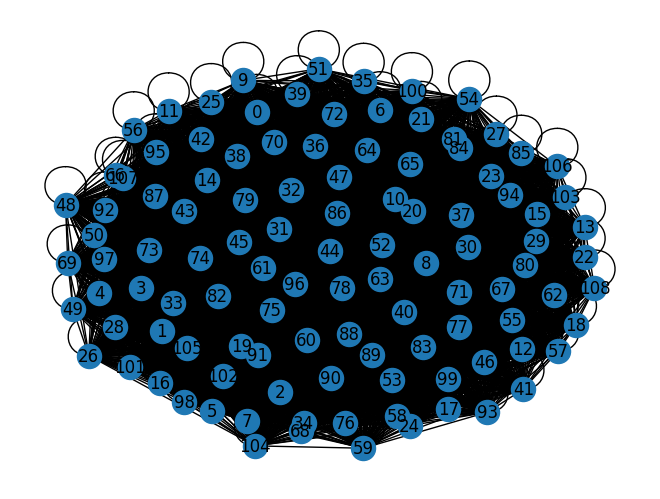

In [37]:


df = pd.read_csv('features_rf.csv')


##### EXTRACT EEG DATA: COLUMN 8 TO 116 ARE THE 109 EEG CHANNELS, AND THE ROWS ARE THE 606 SAMPLES FOR EACH CHANNEL
eeg_data = df.iloc[:, 8:117].values

# Reshape the data to (num_samples, num_channels)
eeg_data = eeg_data.reshape(-1, 109) #eeg_data is a 2D array where rows are the samples, columns are channels

# Class labels are in the 117th column
y_column_name = 'CPC'




##### CREATE A FULLY CONNECTED GRAPH FOR EACH SAMPLE USING GAUSSIAN SIMILARITY FOR EDGE WEIGHTS
def gaussian_similarity(x, sigma=1.0):
    pairwise_distances = squareform(pdist(x, 'euclidean'))

    # shape of pairwise_distances=(109,109)


    return np.exp(-(pairwise_distances ** 2) / (2 * (sigma ** 2)))

def create_graph(eeg_data, label, sigma=1.0):
    #Here, eeg_data is a single row(single sample)
    # Ensure that eeg_data is a 2D array(one row and multiple columns)
    x = np.atleast_2d(eeg_data)
    x=x.reshape(-1, 1) #Reshape it into 1 column and multiple rows


    #The Gaussian similarity function is then applied to the EEG data to obtain an adjacency matrix.
    #This matrix represents the strength of connections between different EEG data points.
    #The non-zero elements of this matrix are used to create an edge index for the graph.

    adjacency_matrix = gaussian_similarity(x, sigma=sigma)
    # adjacency_matrix.shape= (109,109)

    edge_index = torch.tensor(np.nonzero(adjacency_matrix), dtype=torch.long)
    edge_weight = torch.tensor(adjacency_matrix[edge_index[0], edge_index[1]], dtype=torch.float)
    x = torch.tensor(x, dtype=torch.float)
    y = torch.tensor(label, dtype=torch.long)  # Use the correct labels

    #EEG data, edge index, edge weights, and labels, are converted into PyTorch tensors and bundled into a Data object.
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight.view(-1, 1), y=y)


# Create a list of Data objects(graphs) for each sample with correct labels
graph_data_list = [create_graph(eeg_data[i], df[y_column_name].iloc[i]) for i in range(len(eeg_data))]




###VISUALIZING THE GRAPH CREATED FROM 1ST SAMPLE
first_graph_data = graph_data_list[0]
# Extract the first Data object from graph_data_list
graph = nx.Graph()
graph.add_edges_from(first_graph_data.edge_index.T.numpy())
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True)
plt.show()


In [56]:
from torch_geometric.nn import global_mean_pool



####### CREATE TRAINING AND TESTING DATA SETS
num_samples = len(graph_data_list)
split_ratio = 0.8

# Split the indices into training and testing sets
split_idx = int(num_samples * split_ratio)
train_idx, test_idx = range(split_idx), range(split_idx, num_samples)

train_loader = DataLoader([graph_data_list[i] for i in train_idx], batch_size=1, shuffle=True)
test_loader = DataLoader([graph_data_list[i] for i in test_idx], batch_size=1, shuffle=False)





####### CREATE A GNN MODEL TO MAKE THE GRAPH PREDICTIONS FROM 1-5
class GNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, output_size)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_weight)
        x = torch.relu(x)
        #First conv layer applied along with relu function, hidden layer size=64
        x = self.conv2(x, edge_index, edge_weight)
        #second conv layer applied, output layer = 5
        x = global_mean_pool(x, data.batch)  # Assumes you have a batch assignment for nodes
        #Mean value of classification of all nodes gives graph classification


        return x

# Initialize the model, loss function, and optimizer
model = GNNModel(input_size=1, hidden_size=64, output_size=5)
#Here input size =1 because there are 109 nodes and each node only has 1 feature(the eeg value)
#Output size is 5 because there are 5 classes
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)






####### TRAIN THE MODEL
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    #For each sample of training data, batch is the Data object(graph), and the GNN model is run on that
    for batch in train_loader:
        output = model(batch)

        # Adjust target tensor to be zero-based
        target = batch.y.view(-1) - 1

        # Ensure the target is a tensor with size [1]
        target = target.unsqueeze(0) if target.dim() == 0 else target

        # Adjust target values to match the range of model outputs
        target = torch.clamp(target, 0, 4).long()

        # Ensure both the output and target have the same dimensionality
        output = output.unsqueeze(0) if output.dim() == 1 else output

        #Target is the target value of that batch(sample), and output is the value predicted by the GNN for that sample
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()




####### EVALUATE THE MODEL ON THE TEST SET
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        test_output = model(batch)

        # Convert model predictions (0 to 4) back to original class indices (1 to 5)
        predicted_labels = torch.argmax(test_output, dim=1) + 1

        all_preds.extend(predicted_labels.numpy())
        all_labels.extend(batch.y.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(all_labels, all_preds)
print(f"Mean Squared Error: {mse:.4f}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(all_labels, all_preds)
print(f"Mean Absolute Error: {mae:.4f}")

# Calculate F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score: {f1:.4f}")









/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Accuracy on the test set: 66.39%
Mean Squared Error: 4.1885
Mean Absolute Error: 1.1393
F1 Score: 0.5298
